# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at forecasting using the data scraper.

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [1]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-05-04 01:42:51--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.110.153, 185.199.108.153, 185.199.111.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41874411 (40M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  39.93M  73.4MB/s    in 0.5s    

2020-05-04 01:42:52 (73.4 MB/s) - ‘coronavirus_timeseries.csv’ saved [41874411/41874411]

     |████████████████████████████████| 1.4MB 4.9MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 460kB 27.6MB/s 
     |████████████████████████████████| 112kB 40.3MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp

In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()

In [3]:
df = pd.read_csv("coronavirus_timeseries.csv")
!gsutil cp coronavirus_timeseries.csv gs://coronaviruspublicdata/coronavirus_timeseries.csv 
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Copying file://coronavirus_timeseries.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/39.9 MiB.                                     


In [4]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2035


We will now construct a list of suitable data at the county level.

In [5]:
def loop_through_geo_codes(df, column='full_county'):
  df_county_list = []
  df['full_county'] = df['state'] + "_" + df['county'] 
  for code in df['full_county'].unique():
    mask = df['full_county'] == code
    df_code = df[mask]
    ts_count = len(df_code)
    if ts_count > 60:
      df_county_list.append(df_code)
  return df_county_list 
county_info = loop_through_geo_codes(df)
print(len(county_info))

56


In [0]:
county_info[0]

,name,level,city,county,state,country,population,lat,long,url,aggregate,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,growthFactor,date,month,weekday,full_county
0,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22,1,2,Flanders_Antwerp
1,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-23,1,3,Flanders_Antwerp
2,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-24,1,4,Flanders_Antwerp
3,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-25,1,5,Flanders_Antwerp
4,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-26,1,6,Flanders_Antwerp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,5815.0,NaN,NaN,NaN,NaN,2181.0,1869.0,NaN,2020-04-26,4,6,Flanders_Antwerp
96,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,5960.0,NaN,NaN,NaN,NaN,2202.0,1884.0,NaN,2020-04-27,4,0,Flanders_Antwerp
97,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,6001.0,NaN,NaN,NaN,NaN,2238.0,1938.0,NaN,2020-04-28,4,1,Flanders_Antwerp
98,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,NaN,Europe/Brussels,6002.0,NaN,NaN,NaN,NaN,2256.0,1985.0,NaN,2020-04-29,4,2,Flanders_Antwerp


In [0]:
county_info[8]['full_county'].values

## Forecasting in Antwerp
We will now piece together some simple tutorial code for forecasting new cases in Antwerp.

In [0]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
print(len(antwerp_df))

100


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.002, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
#sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

In [0]:
import matplotlib.pyplot as plt
def train(x_train_full, y_train_full, test, test_first, scaler, config_default):
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, scaler)
  evaluate_plot_multi(model, test_first, config, X_test, scaler)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_orig, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test_orig)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.axvline(x=config['seq_len'], label='Predictions start'.format(config["seq_len"]))
  plt.legend();
  wandb.log({"test":plt})
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.Image(plt, caption="Plot")
  large_mse = tf.keras.losses.MSE(
      scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config, trg=None, known_colums_indices=None):
  """
  start_rows:np.array of dimension ()
  """
  start_rows=np.expand_dims(start_rows, axis=0)
  trg = np.expand_dims(trg, axis=0)
  print(start_rows)
  print(start_rows.shape)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    if trg and known_colums_indices:
      for target in known_colums_indices:
        out[:, :, target] = trg[:, i, target]
      targ[:, i, :]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


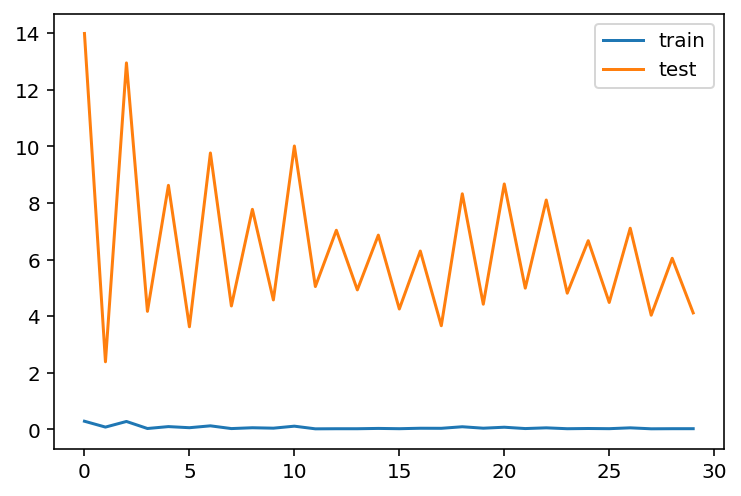

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Forecasting on all county levels
Now that we have loooked at Antwerp specifically we will design a general function to work on all geographic counties.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

def run_geo_sweeps(county_info, start_idx=0, end_idx=1, test_columns=[]):
  for s in range(start_idx, end_idx):
    county = county_info[s].fillna(0)
    county_name = county['full_county'].values[0]
    config_default = {"epochs":30, "validation_split":0.1, 
            "loss":"mean_squared_error", "optimizer":'adam', 
            "geo_segment":county_name, "seq_len":7, "train_steps":60, 
            "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
            "beta":0.899, "additional_features":["none"]}
    county['new_cases'] = county.cases.diff()
    r = RobustScaler()
    x_train_full = county[['deaths', 'new_cases']][1:config_default["train_steps"]]
    x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
    y_train_full = x_train_full
    r_test = RobustScaler()
    test_orig = county[['deaths', 'new_cases']][60:]
    test = pd.DataFrame(r_test.fit_transform(test_orig), columns=["deaths", "new_cases"])
    sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
    wandb.agent(sweep_id, lambda:train(x_train_full, y_train_full, test, test_orig, r_test, config_default))


In [0]:
run_geo_sweeps(county_info, 8, 28)

### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library 


In [0]:
import os
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data
from flood_forecast.trainer import train_function

In [47]:
def make_config_file(file_path, df_len):
  run = wandb.init(project="covid-forecast")
  wandb_config = wandb.config
  train_number = df_len * .7
  validation_number = df_len *.9
  config_default={                 
    "model_name": "MultiAttnHeadSimple",
    "model_type": "PyTorch",
    "model_params": {
      "number_time_series":3,
      "seq_len":wandb_config["forecast_history"], 
      "output_seq_len":wandb_config["out_seq_length"],
      "forecast_length":wandb_config["out_seq_length"]
     },
    "dataset_params":
    {  "class": "default",
       "training_path": file_path,
       "validation_path": file_path,
       "test_path": file_path,
       "batch_size":wandb_config["batch_size"],
       "forecast_history":wandb_config["forecast_history"],
       "forecast_length":wandb_config["out_seq_length"],
       "train_end": int(train_number),
       "valid_start":int(train_number+1),
       "valid_end": int(validation_number),
       "target_col": ["new_cases"],
       "relevant_cols": ["new_cases", "month", "weekday"],
       "scaler": "StandardScaler", 
       "interpolate": False
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": "Adam",
       "optim_params":
       {

       },
       "lr": wandb_config["lr"],
       "epochs": 10,
       "batch_size":wandb_config["batch_size"]
    
    },
    "GCS": False,
    
    "wandb": {
       "name": "multihead_pytorch_antwerp",
       "tags": ["covid_run", "circleci"],
       "project": "covid-forecast"
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2020-04-21",
          "hours_to_forecast":10, 
          "test_csv_path":file_path,
          "decoder_params":{
              "decoder_function": "simple_decode", 
            "unsqueeze_dim": 1
          },
          "dataset_params":{
             "file_path": file_path,
             "forecast_history":wandb_config["forecast_history"],
             "forecast_length":wandb_config["out_seq_length"],
             "relevant_cols": ["new_cases", "month", "weekday"],
             "target_col": ["new_cases"],
             "scaling": "StandardScaler",
             "interpolate_param": False
          }
      }
  }
  print(config_default)
  wandb.config = config_default
  return config_default
county_info[0]['datetime'] = county_info[0]['date']
county_info[0]['precip'] = 0
county_info[0]['temp'] = 0
county_info[0] = county_info[0].fillna(0)
county_info[0]['new_cases'] = county_info[0]['cases'].diff()
county_info[0].iloc[0]['new_cases'] = 0
county_info[0] = county_info[0].fillna(0)
county_info[0].to_csv("antwerp.csv")
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "lr":{
            "values":[0.001, 0.002, 0.004, 0.01]
        },
        "forecast_history":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        },
        "out_seq_length":{
            "values":[1, 2, 3]
        }
    }
}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We will now combine Wandb parameter sweeps with flood forecast

In [0]:
len_csv = len(county_info[0])
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
wandb.agent(sweep_id, lambda:train_function("PyTorch", make_config_file("antwerp.csv", len_csv)))


Create sweep with ID: yw9zbqtn
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/yw9zbqtn
wandb: Agent Starting Run: favq6tdk with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.001
	out_seq_length: 1
wandb: Agent Started Run: favq6tdk


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
11.736990986595629
The number of items in train is: 
34
The loss for epoch 0
0.3452056172528126
The running loss is:
24.813077855855227
The number of items in train is: 
34
The loss for epoch 1
0.7297964075251537
The running loss is:
28.300584806129336
The number of items in train is: 
34
The loss for epoch 2
0.8323701413567451
The running loss is:
10.4155727809557
The number of items in train is: 
34
The loss for epoch 3
0.30634037591046176
The running loss is:
11.473218071194424
The number of items in train is: 
34
The loss for epoch 4
0.33744759032924776
The running loss is:
8.870212249457836
The number of items in train is: 
34
The loss for epoch 5
0.2608885955722893
The running loss is:
8.28752523707226
The number of items in train is: 
34
The loss for epoch 6
0.24375074226683116
The running loss is:
7.280146740449709
The number of items in train is: 
34
The loss for epoch 7
0.2141219629544032
The running loss is:
12.525580656249076
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  102.806030
91          91  Antwerp, Flanders, Belgium  ...             91   71.026802
92          92  Antwerp, Flanders, Belgium  ...             92   56.383720
93          93  Antwerp, Flanders, Belgium  ...             93   51.088078
94          94  Antwerp, Flanders, Belgium  ...             94   50.891293
95          95  Antwerp, Flanders, Belgium  ...             95   53.475834
96          96  Antwerp, Flanders, Belgium  ...             96   57.577534
97          97  Antwerp, Flanders, Belgium  ...             97   43.663624
98          98  Antwerp, Flanders, Belgium  ...             98   38.765736
99          99  Antwerp, Flanders, Belgium  ...             99   38.785915

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: favq6tdk 

wandb: Agent Starting Run: qej41xa6 with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.001
	out_seq_length: 2
wandb: Agent Started Run: qej41xa6


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
20.978312958031893
The number of items in train is: 
34
The loss for epoch 0
0.6170092046479968
The running loss is:
39.80216880142689
The number of items in train is: 
34
The loss for epoch 1
1.170652023571379
The running loss is:
24.19058443978429
The number of items in train is: 
34
The loss for epoch 2
0.7114877776407144
The running loss is:
20.301503472030163
The number of items in train is: 
34
The loss for epoch 3
0.5971030432950047
The running loss is:
18.146781336516142
The number of items in train is: 
34
The loss for epoch 4
0.53372886283871
The running loss is:
20.873035572469234
The number of items in train is: 
34
The loss for epoch 5
0.6139128109549775
The running loss is:
17.74494293704629
The number of items in train is: 
34
The loss for epoch 6
0.5219100863837144
The running loss is:
18.19329888187349
The number of items in train is: 
34
The loss for epoch 7
0.5350970259374556
The running loss is:
14.98734188452363
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  57.193180
91          91  Antwerp, Flanders, Belgium  ...             91  23.370998
92          92  Antwerp, Flanders, Belgium  ...             92  14.213340
93          93  Antwerp, Flanders, Belgium  ...             93  13.168525
94          94  Antwerp, Flanders, Belgium  ...             94  14.792251
95          95  Antwerp, Flanders, Belgium  ...             95  17.293728
96          96  Antwerp, Flanders, Belgium  ...             96  20.083920
97          97  Antwerp, Flanders, Belgium  ...             97   9.197349
98          98  Antwerp, Flanders, Belgium  ...             98   7.583842
99          99  Antwerp, Flanders, Belgium  ...             99   9.020511

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: qej41xa6 

wandb: Agent Starting Run: 4lsu567z with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.001
	out_seq_length: 3
wandb: Agent Started Run: 4lsu567z


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.944805666804314
The number of items in train is: 
33
The loss for epoch 0
0.6649941111152823
The running loss is:
39.04568848013878
The number of items in train is: 
33
The loss for epoch 1
1.1832026812163265
The running loss is:
22.351303592324257
The number of items in train is: 
33
The loss for epoch 2
0.6773122300704321
The running loss is:
24.924195021390915
The number of items in train is: 
33
The loss for epoch 3
0.7552786370118459
The running loss is:
17.094573065638542
The number of items in train is: 
33
The loss for epoch 4
0.5180173656254103
The running loss is:
22.243711099028587
The number of items in train is: 
33
The loss for epoch 5
0.6740518514857148
The running loss is:
14.625111401081085
The number of items in train is: 
33
The loss for epoch 6
0.4431851939721541
The running loss is:
18.527046501636505
The number of items in train is: 
33
The loss for epoch 7
0.5614256515647426
The running loss is:
13.53986869752407
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  155.923538
91          91  Antwerp, Flanders, Belgium  ...             91  151.458740
92          92  Antwerp, Flanders, Belgium  ...             92  150.204483
93          93  Antwerp, Flanders, Belgium  ...             93  150.787048
94          94  Antwerp, Flanders, Belgium  ...             94  152.420502
95          95  Antwerp, Flanders, Belgium  ...             95  154.655197
96          96  Antwerp, Flanders, Belgium  ...             96  157.233871
97          97  Antwerp, Flanders, Belgium  ...             97  150.908249
98          98  Antwerp, Flanders, Belgium  ...             98  148.589386
99          99  Antwerp, Flanders, Belgium  ...             99  148.562866

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 4lsu567z 

wandb: Agent Starting Run: gga943m2 with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.002
	out_seq_length: 1
wandb: Agent Started Run: gga943m2


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
11.736990986595629
The number of items in train is: 
34
The loss for epoch 0
0.3452056172528126
The running loss is:
24.813077855855227
The number of items in train is: 
34
The loss for epoch 1
0.7297964075251537
The running loss is:
28.300584806129336
The number of items in train is: 
34
The loss for epoch 2
0.8323701413567451
The running loss is:
10.4155727809557
The number of items in train is: 
34
The loss for epoch 3
0.30634037591046176
The running loss is:
11.473218071194424
The number of items in train is: 
34
The loss for epoch 4
0.33744759032924776
The running loss is:
8.870212249457836
The number of items in train is: 
34
The loss for epoch 5
0.2608885955722893
The running loss is:
8.28752523707226
The number of items in train is: 
34
The loss for epoch 6
0.24375074226683116
The running loss is:
7.280146740449709
The number of items in train is: 
34
The loss for epoch 7
0.2141219629544032
The running loss is:
12.525580656249076
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  102.806030
91          91  Antwerp, Flanders, Belgium  ...             91   71.026802
92          92  Antwerp, Flanders, Belgium  ...             92   56.383720
93          93  Antwerp, Flanders, Belgium  ...             93   51.088078
94          94  Antwerp, Flanders, Belgium  ...             94   50.891293
95          95  Antwerp, Flanders, Belgium  ...             95   53.475834
96          96  Antwerp, Flanders, Belgium  ...             96   57.577534
97          97  Antwerp, Flanders, Belgium  ...             97   43.663624
98          98  Antwerp, Flanders, Belgium  ...             98   38.765736
99          99  Antwerp, Flanders, Belgium  ...             99   38.785915

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: gga943m2 

wandb: Agent Starting Run: 8blainoj with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.002
	out_seq_length: 2
wandb: Agent Started Run: 8blainoj


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
20.978312958031893
The number of items in train is: 
34
The loss for epoch 0
0.6170092046479968
The running loss is:
39.80216880142689
The number of items in train is: 
34
The loss for epoch 1
1.170652023571379
The running loss is:
24.19058443978429
The number of items in train is: 
34
The loss for epoch 2
0.7114877776407144
The running loss is:
20.301503472030163
The number of items in train is: 
34
The loss for epoch 3
0.5971030432950047
The running loss is:
18.146781336516142
The number of items in train is: 
34
The loss for epoch 4
0.53372886283871
The running loss is:
20.873035572469234
The number of items in train is: 
34
The loss for epoch 5
0.6139128109549775
The running loss is:
17.74494293704629
The number of items in train is: 
34
The loss for epoch 6
0.5219100863837144
The running loss is:
18.19329888187349
The number of items in train is: 
34
The loss for epoch 7
0.5350970259374556
The running loss is:
14.98734188452363
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  57.193180
91          91  Antwerp, Flanders, Belgium  ...             91  23.370998
92          92  Antwerp, Flanders, Belgium  ...             92  14.213340
93          93  Antwerp, Flanders, Belgium  ...             93  13.168525
94          94  Antwerp, Flanders, Belgium  ...             94  14.792251
95          95  Antwerp, Flanders, Belgium  ...             95  17.293728
96          96  Antwerp, Flanders, Belgium  ...             96  20.083920
97          97  Antwerp, Flanders, Belgium  ...             97   9.197349
98          98  Antwerp, Flanders, Belgium  ...             98   7.583842
99          99  Antwerp, Flanders, Belgium  ...             99   9.020511

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 8blainoj 

wandb: Agent Starting Run: aomxdwio with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.002
	out_seq_length: 3
wandb: Agent Started Run: aomxdwio


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.944805666804314
The number of items in train is: 
33
The loss for epoch 0
0.6649941111152823
The running loss is:
39.04568848013878
The number of items in train is: 
33
The loss for epoch 1
1.1832026812163265
The running loss is:
22.351303592324257
The number of items in train is: 
33
The loss for epoch 2
0.6773122300704321
The running loss is:
24.924195021390915
The number of items in train is: 
33
The loss for epoch 3
0.7552786370118459
The running loss is:
17.094573065638542
The number of items in train is: 
33
The loss for epoch 4
0.5180173656254103
The running loss is:
22.243711099028587
The number of items in train is: 
33
The loss for epoch 5
0.6740518514857148
The running loss is:
14.625111401081085
The number of items in train is: 
33
The loss for epoch 6
0.4431851939721541
The running loss is:
18.527046501636505
The number of items in train is: 
33
The loss for epoch 7
0.5614256515647426
The running loss is:
13.53986869752407
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  155.923538
91          91  Antwerp, Flanders, Belgium  ...             91  151.458740
92          92  Antwerp, Flanders, Belgium  ...             92  150.204483
93          93  Antwerp, Flanders, Belgium  ...             93  150.787048
94          94  Antwerp, Flanders, Belgium  ...             94  152.420502
95          95  Antwerp, Flanders, Belgium  ...             95  154.655197
96          96  Antwerp, Flanders, Belgium  ...             96  157.233871
97          97  Antwerp, Flanders, Belgium  ...             97  150.908249
98          98  Antwerp, Flanders, Belgium  ...             98  148.589386
99          99  Antwerp, Flanders, Belgium  ...             99  148.562866

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: aomxdwio 

wandb: Agent Starting Run: 30hdvsam with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.004
	out_seq_length: 1
wandb: Agent Started Run: 30hdvsam


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
11.736990986595629
The number of items in train is: 
34
The loss for epoch 0
0.3452056172528126
The running loss is:
24.813077855855227
The number of items in train is: 
34
The loss for epoch 1
0.7297964075251537
The running loss is:
28.300584806129336
The number of items in train is: 
34
The loss for epoch 2
0.8323701413567451
The running loss is:
10.4155727809557
The number of items in train is: 
34
The loss for epoch 3
0.30634037591046176
The running loss is:
11.473218071194424
The number of items in train is: 
34
The loss for epoch 4
0.33744759032924776
The running loss is:
8.870212249457836
The number of items in train is: 
34
The loss for epoch 5
0.2608885955722893
The running loss is:
8.28752523707226
The number of items in train is: 
34
The loss for epoch 6
0.24375074226683116
The running loss is:
7.280146740449709
The number of items in train is: 
34
The loss for epoch 7
0.2141219629544032
The running loss is:
12.525580656249076
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  102.806030
91          91  Antwerp, Flanders, Belgium  ...             91   71.026802
92          92  Antwerp, Flanders, Belgium  ...             92   56.383720
93          93  Antwerp, Flanders, Belgium  ...             93   51.088078
94          94  Antwerp, Flanders, Belgium  ...             94   50.891293
95          95  Antwerp, Flanders, Belgium  ...             95   53.475834
96          96  Antwerp, Flanders, Belgium  ...             96   57.577534
97          97  Antwerp, Flanders, Belgium  ...             97   43.663624
98          98  Antwerp, Flanders, Belgium  ...             98   38.765736
99          99  Antwerp, Flanders, Belgium  ...             99   38.785915

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 30hdvsam 

wandb: Agent Starting Run: t62et1z8 with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.004
	out_seq_length: 2
wandb: Agent Started Run: t62et1z8


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
20.978312958031893
The number of items in train is: 
34
The loss for epoch 0
0.6170092046479968
The running loss is:
39.80216880142689
The number of items in train is: 
34
The loss for epoch 1
1.170652023571379
The running loss is:
24.19058443978429
The number of items in train is: 
34
The loss for epoch 2
0.7114877776407144
The running loss is:
20.301503472030163
The number of items in train is: 
34
The loss for epoch 3
0.5971030432950047
The running loss is:
18.146781336516142
The number of items in train is: 
34
The loss for epoch 4
0.53372886283871
The running loss is:
20.873035572469234
The number of items in train is: 
34
The loss for epoch 5
0.6139128109549775
The running loss is:
17.74494293704629
The number of items in train is: 
34
The loss for epoch 6
0.5219100863837144
The running loss is:
18.19329888187349
The number of items in train is: 
34
The loss for epoch 7
0.5350970259374556
The running loss is:
14.98734188452363
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  57.193180
91          91  Antwerp, Flanders, Belgium  ...             91  23.370998
92          92  Antwerp, Flanders, Belgium  ...             92  14.213340
93          93  Antwerp, Flanders, Belgium  ...             93  13.168525
94          94  Antwerp, Flanders, Belgium  ...             94  14.792251
95          95  Antwerp, Flanders, Belgium  ...             95  17.293728
96          96  Antwerp, Flanders, Belgium  ...             96  20.083920
97          97  Antwerp, Flanders, Belgium  ...             97   9.197349
98          98  Antwerp, Flanders, Belgium  ...             98   7.583842
99          99  Antwerp, Flanders, Belgium  ...             99   9.020511

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: t62et1z8 

wandb: Agent Starting Run: 4b3oei6w with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.004
	out_seq_length: 3
wandb: Agent Started Run: 4b3oei6w


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.944805666804314
The number of items in train is: 
33
The loss for epoch 0
0.6649941111152823
The running loss is:
39.04568848013878
The number of items in train is: 
33
The loss for epoch 1
1.1832026812163265
The running loss is:
22.351303592324257
The number of items in train is: 
33
The loss for epoch 2
0.6773122300704321
The running loss is:
24.924195021390915
The number of items in train is: 
33
The loss for epoch 3
0.7552786370118459
The running loss is:
17.094573065638542
The number of items in train is: 
33
The loss for epoch 4
0.5180173656254103
The running loss is:
22.243711099028587
The number of items in train is: 
33
The loss for epoch 5
0.6740518514857148
The running loss is:
14.625111401081085
The number of items in train is: 
33
The loss for epoch 6
0.4431851939721541
The running loss is:
18.527046501636505
The number of items in train is: 
33
The loss for epoch 7
0.5614256515647426
The running loss is:
13.53986869752407
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  155.923538
91          91  Antwerp, Flanders, Belgium  ...             91  151.458740
92          92  Antwerp, Flanders, Belgium  ...             92  150.204483
93          93  Antwerp, Flanders, Belgium  ...             93  150.787048
94          94  Antwerp, Flanders, Belgium  ...             94  152.420502
95          95  Antwerp, Flanders, Belgium  ...             95  154.655197
96          96  Antwerp, Flanders, Belgium  ...             96  157.233871
97          97  Antwerp, Flanders, Belgium  ...             97  150.908249
98          98  Antwerp, Flanders, Belgium  ...             98  148.589386
99          99  Antwerp, Flanders, Belgium  ...             99  148.562866

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 4b3oei6w 

wandb: Agent Starting Run: 5vlib7vq with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.01
	out_seq_length: 1
wandb: Agent Started Run: 5vlib7vq


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
11.736990986595629
The number of items in train is: 
34
The loss for epoch 0
0.3452056172528126
The running loss is:
24.813077855855227
The number of items in train is: 
34
The loss for epoch 1
0.7297964075251537
The running loss is:
28.300584806129336
The number of items in train is: 
34
The loss for epoch 2
0.8323701413567451
The running loss is:
10.4155727809557
The number of items in train is: 
34
The loss for epoch 3
0.30634037591046176
The running loss is:
11.473218071194424
The number of items in train is: 
34
The loss for epoch 4
0.33744759032924776
The running loss is:
8.870212249457836
The number of items in train is: 
34
The loss for epoch 5
0.2608885955722893
The running loss is:
8.28752523707226
The number of items in train is: 
34
The loss for epoch 6
0.24375074226683116
The running loss is:
7.280146740449709
The number of items in train is: 
34
The loss for epoch 7
0.2141219629544032
The running loss is:
12.525580656249076
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  102.806030
91          91  Antwerp, Flanders, Belgium  ...             91   71.026802
92          92  Antwerp, Flanders, Belgium  ...             92   56.383720
93          93  Antwerp, Flanders, Belgium  ...             93   51.088078
94          94  Antwerp, Flanders, Belgium  ...             94   50.891293
95          95  Antwerp, Flanders, Belgium  ...             95   53.475834
96          96  Antwerp, Flanders, Belgium  ...             96   57.577534
97          97  Antwerp, Flanders, Belgium  ...             97   43.663624
98          98  Antwerp, Flanders, Belgium  ...             98   38.765736
99          99  Antwerp, Flanders, Belgium  ...             99   38.785915

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 5vlib7vq 

wandb: Agent Starting Run: qkoip9zi with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.01
	out_seq_length: 2
wandb: Agent Started Run: qkoip9zi


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
20.978312958031893
The number of items in train is: 
34
The loss for epoch 0
0.6170092046479968
The running loss is:
39.80216880142689
The number of items in train is: 
34
The loss for epoch 1
1.170652023571379
The running loss is:
24.19058443978429
The number of items in train is: 
34
The loss for epoch 2
0.7114877776407144
The running loss is:
20.301503472030163
The number of items in train is: 
34
The loss for epoch 3
0.5971030432950047
The running loss is:
18.146781336516142
The number of items in train is: 
34
The loss for epoch 4
0.53372886283871
The running loss is:
20.873035572469234
The number of items in train is: 
34
The loss for epoch 5
0.6139128109549775
The running loss is:
17.74494293704629
The number of items in train is: 
34
The loss for epoch 6
0.5219100863837144
The running loss is:
18.19329888187349
The number of items in train is: 
34
The loss for epoch 7
0.5350970259374556
The running loss is:
14.98734188452363
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  57.193180
91          91  Antwerp, Flanders, Belgium  ...             91  23.370998
92          92  Antwerp, Flanders, Belgium  ...             92  14.213340
93          93  Antwerp, Flanders, Belgium  ...             93  13.168525
94          94  Antwerp, Flanders, Belgium  ...             94  14.792251
95          95  Antwerp, Flanders, Belgium  ...             95  17.293728
96          96  Antwerp, Flanders, Belgium  ...             96  20.083920
97          97  Antwerp, Flanders, Belgium  ...             97   9.197349
98          98  Antwerp, Flanders, Belgium  ...             98   7.583842
99          99  Antwerp, Flanders, Belgium  ...             99   9.020511

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: qkoip9zi 

wandb: Agent Starting Run: vrtzj2tq with config:
	batch_size: 2
	forecast_history: 1
	lr: 0.01
	out_seq_length: 3
wandb: Agent Started Run: vrtzj2tq


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 1, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 1, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
21.944805666804314
The number of items in train is: 
33
The loss for epoch 0
0.6649941111152823
The running loss is:
39.04568848013878
The number of items in train is: 
33
The loss for epoch 1
1.1832026812163265
The running loss is:
22.351303592324257
The number of items in train is: 
33
The loss for epoch 2
0.6773122300704321
The running loss is:
24.924195021390915
The number of items in train is: 
33
The loss for epoch 3
0.7552786370118459
The running loss is:
17.094573065638542
The number of items in train is: 
33
The loss for epoch 4
0.5180173656254103
The running loss is:
22.243711099028587
The number of items in train is: 
33
The loss for epoch 5
0.6740518514857148
The running loss is:
14.625111401081085
The number of items in train is: 
33
The loss for epoch 6
0.4431851939721541
The running loss is:
18.527046501636505
The number of items in train is: 
33
The loss for epoch 7
0.5614256515647426
The running loss is:
13.53986869752407
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  155.923538
91          91  Antwerp, Flanders, Belgium  ...             91  151.458740
92          92  Antwerp, Flanders, Belgium  ...             92  150.204483
93          93  Antwerp, Flanders, Belgium  ...             93  150.787048
94          94  Antwerp, Flanders, Belgium  ...             94  152.420502
95          95  Antwerp, Flanders, Belgium  ...             95  154.655197
96          96  Antwerp, Flanders, Belgium  ...             96  157.233871
97          97  Antwerp, Flanders, Belgium  ...             97  150.908249
98          98  Antwerp, Flanders, Belgium  ...             98  148.589386
99          99  Antwerp, Flanders, Belgium  ...             99  148.562866

[11 rows x 32 columns]


/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: vrtzj2tq 

wandb: Agent Starting Run: 0n6zfk4d with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.001
	out_seq_length: 1
wandb: Agent Started Run: 0n6zfk4d


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.926211021491326
The number of items in train is: 
34
The loss for epoch 0
0.2331238535732743
The running loss is:
45.07759717758745
The number of items in train is: 
34
The loss for epoch 1
1.3258116816937484
The running loss is:
17.52304550539702
The number of items in train is: 
34
The loss for epoch 2
0.5153836913352066
The running loss is:
19.223857637960464
The number of items in train is: 
34
The loss for epoch 3
0.5654075775870725
The running loss is:
17.085357565616505
The number of items in train is: 
34
The loss for epoch 4
0.5025105166357795
The running loss is:
26.338379439665005
The number of items in train is: 
34
The loss for epoch 5
0.7746582188136766
The running loss is:
12.023202999029309
The number of items in train is: 
34
The loss for epoch 6
0.3536236176185091
The running loss is:
10.84097226295853
The number of items in train is: 
34
The loss for epoch 7
0.3188521253811332
The running loss is:
9.669757608440705
The number

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  157.648819
91          91  Antwerp, Flanders, Belgium  ...             91  163.518372
92          92  Antwerp, Flanders, Belgium  ...             92  164.045349
93          93  Antwerp, Flanders, Belgium  ...             93  172.106415
94          94  Antwerp, Flanders, Belgium  ...             94  178.464401
95          95  Antwerp, Flanders, Belgium  ...             95  189.383789
96          96  Antwerp, Flanders, Belgium  ...             96  200.001709
97          97  Antwerp, Flanders, Belgium  ...             97  199.110626
98          98  Antwerp, Flanders, Belgium  ...             98  195.757309
99          99  Antwerp, Flanders, Belgium  ...             99  198.477

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 0n6zfk4d 

wandb: Agent Starting Run: rukyahky with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.001
	out_seq_length: 2
wandb: Agent Started Run: rukyahky


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.949298333376646
The number of items in train is: 
33
The loss for epoch 0
0.665130252526565
The running loss is:
28.23917729780078
The number of items in train is: 
33
The loss for epoch 1
0.8557326453879024
The running loss is:
20.276927853934467
The number of items in train is: 
33
The loss for epoch 2
0.6144523592101354
The running loss is:
22.451173399109393
The number of items in train is: 
33
The loss for epoch 3
0.6803385878517998
The running loss is:
18.38559128716588
The number of items in train is: 
33
The loss for epoch 4
0.5571391299141176
The running loss is:
22.97731645638123
The number of items in train is: 
33
The loss for epoch 5
0.6962823168600373
The running loss is:
15.07943250075914
The number of items in train is: 
33
The loss for epoch 6
0.45695250002300425
The running loss is:
19.21207500435412
The number of items in train is: 
33
The loss for epoch 7
0.582184091041034
The running loss is:
15.169635845348239
The number 

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
88          88  Antwerp, Flanders, Belgium  ...             88   0.000000
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  85.166397
91          91  Antwerp, Flanders, Belgium  ...             91  92.528320
92          92  Antwerp, Flanders, Belgium  ...             92  80.694923
93          93  Antwerp, Flanders, Belgium  ...             93  80.634438
94          94  Antwerp, Flanders, Belgium  ...             94  77.969078
95          95  Antwerp, Flanders, Belgium  ...             95  78.311951
96          96  Antwerp, Flanders, Belgium  ...             96  78.250671
97          97  Antwerp, Flanders, Belgium  ...             97  72.981339
98          98  Antwerp, Flanders, Belgium  ...             98  72.524170
99          99  Antwerp, Flanders, Belgium  ...             99  71.966652

[12 rows

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: rukyahky 

wandb: Agent Starting Run: vspjwn1i with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.001
	out_seq_length: 3
wandb: Agent Started Run: vspjwn1i


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.00543548539281
The number of items in train is: 
33
The loss for epoch 0
0.6365283480422064
The running loss is:
31.75407860055566
The number of items in train is: 
33
The loss for epoch 1
0.9622448060774442
The running loss is:
21.44613552838564
The number of items in train is: 
33
The loss for epoch 2
0.6498828947995648
The running loss is:
24.966893255710602
The number of items in train is: 
33
The loss for epoch 3
0.7565725229003213
The running loss is:
19.329234207049012
The number of items in train is: 
33
The loss for epoch 4
0.5857343699105761
The running loss is:
22.27110578864813
The number of items in train is: 
33
The loss for epoch 5
0.6748819935953978
The running loss is:
17.701665556058288
The number of items in train is: 
33
The loss for epoch 6
0.5364141077593421
The running loss is:
25.693841315805912
The number of items in train is: 
33
The loss for epoch 7
0.7786012519941186
The running loss is:
15.266029976308346
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.231934
91          91  Antwerp, Flanders, Belgium  ...             91  173.492966
92          92  Antwerp, Flanders, Belgium  ...             92  176.606049
93          93  Antwerp, Flanders, Belgium  ...             93  182.805557
94          94  Antwerp, Flanders, Belgium  ...             94  187.054810
95          95  Antwerp, Flanders, Belgium  ...             95  192.212372
96          96  Antwerp, Flanders, Belgium  ...             96  196.656876
97          97  Antwerp, Flanders, Belgium  ...             97  206.050522
98          98  Antwerp, Flanders, Belgium  ...             98  200.513489
99          99  Antwerp, Flanders, Belgium  ...             99  204.270

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: vspjwn1i 

wandb: Agent Starting Run: skf5u077 with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.002
	out_seq_length: 1
wandb: Agent Started Run: skf5u077


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.926211021491326
The number of items in train is: 
34
The loss for epoch 0
0.2331238535732743
The running loss is:
45.07759717758745
The number of items in train is: 
34
The loss for epoch 1
1.3258116816937484
The running loss is:
17.52304550539702
The number of items in train is: 
34
The loss for epoch 2
0.5153836913352066
The running loss is:
19.223857637960464
The number of items in train is: 
34
The loss for epoch 3
0.5654075775870725
The running loss is:
17.085357565616505
The number of items in train is: 
34
The loss for epoch 4
0.5025105166357795
The running loss is:
26.338379439665005
The number of items in train is: 
34
The loss for epoch 5
0.7746582188136766
The running loss is:
12.023202999029309
The number of items in train is: 
34
The loss for epoch 6
0.3536236176185091
The running loss is:
10.84097226295853
The number of items in train is: 
34
The loss for epoch 7
0.3188521253811332
The running loss is:
9.669757608440705
The number

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  157.648819
91          91  Antwerp, Flanders, Belgium  ...             91  163.518372
92          92  Antwerp, Flanders, Belgium  ...             92  164.045349
93          93  Antwerp, Flanders, Belgium  ...             93  172.106415
94          94  Antwerp, Flanders, Belgium  ...             94  178.464401
95          95  Antwerp, Flanders, Belgium  ...             95  189.383789
96          96  Antwerp, Flanders, Belgium  ...             96  200.001709
97          97  Antwerp, Flanders, Belgium  ...             97  199.110626
98          98  Antwerp, Flanders, Belgium  ...             98  195.757309
99          99  Antwerp, Flanders, Belgium  ...             99  198.477

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: skf5u077 

wandb: Agent Starting Run: kwo2n9nm with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.002
	out_seq_length: 2
wandb: Agent Started Run: kwo2n9nm


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.949298333376646
The number of items in train is: 
33
The loss for epoch 0
0.665130252526565
The running loss is:
28.23917729780078
The number of items in train is: 
33
The loss for epoch 1
0.8557326453879024
The running loss is:
20.276927853934467
The number of items in train is: 
33
The loss for epoch 2
0.6144523592101354
The running loss is:
22.451173399109393
The number of items in train is: 
33
The loss for epoch 3
0.6803385878517998
The running loss is:
18.38559128716588
The number of items in train is: 
33
The loss for epoch 4
0.5571391299141176
The running loss is:
22.97731645638123
The number of items in train is: 
33
The loss for epoch 5
0.6962823168600373
The running loss is:
15.07943250075914
The number of items in train is: 
33
The loss for epoch 6
0.45695250002300425
The running loss is:
19.21207500435412
The number of items in train is: 
33
The loss for epoch 7
0.582184091041034
The running loss is:
15.169635845348239
The number 

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
88          88  Antwerp, Flanders, Belgium  ...             88   0.000000
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  85.166397
91          91  Antwerp, Flanders, Belgium  ...             91  92.528320
92          92  Antwerp, Flanders, Belgium  ...             92  80.694923
93          93  Antwerp, Flanders, Belgium  ...             93  80.634438
94          94  Antwerp, Flanders, Belgium  ...             94  77.969078
95          95  Antwerp, Flanders, Belgium  ...             95  78.311951
96          96  Antwerp, Flanders, Belgium  ...             96  78.250671
97          97  Antwerp, Flanders, Belgium  ...             97  72.981339
98          98  Antwerp, Flanders, Belgium  ...             98  72.524170
99          99  Antwerp, Flanders, Belgium  ...             99  71.966652

[12 rows

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: kwo2n9nm 

wandb: Agent Starting Run: 27c31yeh with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.002
	out_seq_length: 3
wandb: Agent Started Run: 27c31yeh


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.00543548539281
The number of items in train is: 
33
The loss for epoch 0
0.6365283480422064
The running loss is:
31.75407860055566
The number of items in train is: 
33
The loss for epoch 1
0.9622448060774442
The running loss is:
21.44613552838564
The number of items in train is: 
33
The loss for epoch 2
0.6498828947995648
The running loss is:
24.966893255710602
The number of items in train is: 
33
The loss for epoch 3
0.7565725229003213
The running loss is:
19.329234207049012
The number of items in train is: 
33
The loss for epoch 4
0.5857343699105761
The running loss is:
22.27110578864813
The number of items in train is: 
33
The loss for epoch 5
0.6748819935953978
The running loss is:
17.701665556058288
The number of items in train is: 
33
The loss for epoch 6
0.5364141077593421
The running loss is:
25.693841315805912
The number of items in train is: 
33
The loss for epoch 7
0.7786012519941186
The running loss is:
15.266029976308346
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.231934
91          91  Antwerp, Flanders, Belgium  ...             91  173.492966
92          92  Antwerp, Flanders, Belgium  ...             92  176.606049
93          93  Antwerp, Flanders, Belgium  ...             93  182.805557
94          94  Antwerp, Flanders, Belgium  ...             94  187.054810
95          95  Antwerp, Flanders, Belgium  ...             95  192.212372
96          96  Antwerp, Flanders, Belgium  ...             96  196.656876
97          97  Antwerp, Flanders, Belgium  ...             97  206.050522
98          98  Antwerp, Flanders, Belgium  ...             98  200.513489
99          99  Antwerp, Flanders, Belgium  ...             99  204.270

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 27c31yeh 

wandb: Agent Starting Run: icihioxa with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.004
	out_seq_length: 1
wandb: Agent Started Run: icihioxa


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.926211021491326
The number of items in train is: 
34
The loss for epoch 0
0.2331238535732743
The running loss is:
45.07759717758745
The number of items in train is: 
34
The loss for epoch 1
1.3258116816937484
The running loss is:
17.52304550539702
The number of items in train is: 
34
The loss for epoch 2
0.5153836913352066
The running loss is:
19.223857637960464
The number of items in train is: 
34
The loss for epoch 3
0.5654075775870725
The running loss is:
17.085357565616505
The number of items in train is: 
34
The loss for epoch 4
0.5025105166357795
The running loss is:
26.338379439665005
The number of items in train is: 
34
The loss for epoch 5
0.7746582188136766
The running loss is:
12.023202999029309
The number of items in train is: 
34
The loss for epoch 6
0.3536236176185091
The running loss is:
10.84097226295853
The number of items in train is: 
34
The loss for epoch 7
0.3188521253811332
The running loss is:
9.669757608440705
The number

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  157.648819
91          91  Antwerp, Flanders, Belgium  ...             91  163.518372
92          92  Antwerp, Flanders, Belgium  ...             92  164.045349
93          93  Antwerp, Flanders, Belgium  ...             93  172.106415
94          94  Antwerp, Flanders, Belgium  ...             94  178.464401
95          95  Antwerp, Flanders, Belgium  ...             95  189.383789
96          96  Antwerp, Flanders, Belgium  ...             96  200.001709
97          97  Antwerp, Flanders, Belgium  ...             97  199.110626
98          98  Antwerp, Flanders, Belgium  ...             98  195.757309
99          99  Antwerp, Flanders, Belgium  ...             99  198.477

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: icihioxa 

wandb: Agent Starting Run: jzz869u5 with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.004
	out_seq_length: 2
wandb: Agent Started Run: jzz869u5


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.949298333376646
The number of items in train is: 
33
The loss for epoch 0
0.665130252526565
The running loss is:
28.23917729780078
The number of items in train is: 
33
The loss for epoch 1
0.8557326453879024
The running loss is:
20.276927853934467
The number of items in train is: 
33
The loss for epoch 2
0.6144523592101354
The running loss is:
22.451173399109393
The number of items in train is: 
33
The loss for epoch 3
0.6803385878517998
The running loss is:
18.38559128716588
The number of items in train is: 
33
The loss for epoch 4
0.5571391299141176
The running loss is:
22.97731645638123
The number of items in train is: 
33
The loss for epoch 5
0.6962823168600373
The running loss is:
15.07943250075914
The number of items in train is: 
33
The loss for epoch 6
0.45695250002300425
The running loss is:
19.21207500435412
The number of items in train is: 
33
The loss for epoch 7
0.582184091041034
The running loss is:
15.169635845348239
The number 

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
88          88  Antwerp, Flanders, Belgium  ...             88   0.000000
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  85.166397
91          91  Antwerp, Flanders, Belgium  ...             91  92.528320
92          92  Antwerp, Flanders, Belgium  ...             92  80.694923
93          93  Antwerp, Flanders, Belgium  ...             93  80.634438
94          94  Antwerp, Flanders, Belgium  ...             94  77.969078
95          95  Antwerp, Flanders, Belgium  ...             95  78.311951
96          96  Antwerp, Flanders, Belgium  ...             96  78.250671
97          97  Antwerp, Flanders, Belgium  ...             97  72.981339
98          98  Antwerp, Flanders, Belgium  ...             98  72.524170
99          99  Antwerp, Flanders, Belgium  ...             99  71.966652

[12 rows

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: jzz869u5 

wandb: Agent Starting Run: 4vrhs88h with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.004
	out_seq_length: 3
wandb: Agent Started Run: 4vrhs88h


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
21.00543548539281
The number of items in train is: 
33
The loss for epoch 0
0.6365283480422064
The running loss is:
31.75407860055566
The number of items in train is: 
33
The loss for epoch 1
0.9622448060774442
The running loss is:
21.44613552838564
The number of items in train is: 
33
The loss for epoch 2
0.6498828947995648
The running loss is:
24.966893255710602
The number of items in train is: 
33
The loss for epoch 3
0.7565725229003213
The running loss is:
19.329234207049012
The number of items in train is: 
33
The loss for epoch 4
0.5857343699105761
The running loss is:
22.27110578864813
The number of items in train is: 
33
The loss for epoch 5
0.6748819935953978
The running loss is:
17.701665556058288
The number of items in train is: 
33
The loss for epoch 6
0.5364141077593421
The running loss is:
25.693841315805912
The number of items in train is: 
33
The loss for epoch 7
0.7786012519941186
The running loss is:
15.266029976308346
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.231934
91          91  Antwerp, Flanders, Belgium  ...             91  173.492966
92          92  Antwerp, Flanders, Belgium  ...             92  176.606049
93          93  Antwerp, Flanders, Belgium  ...             93  182.805557
94          94  Antwerp, Flanders, Belgium  ...             94  187.054810
95          95  Antwerp, Flanders, Belgium  ...             95  192.212372
96          96  Antwerp, Flanders, Belgium  ...             96  196.656876
97          97  Antwerp, Flanders, Belgium  ...             97  206.050522
98          98  Antwerp, Flanders, Belgium  ...             98  200.513489
99          99  Antwerp, Flanders, Belgium  ...             99  204.270

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 4vrhs88h 

wandb: Agent Starting Run: r2mnfi6q with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.01
	out_seq_length: 1
wandb: Agent Started Run: r2mnfi6q


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
7.926211021491326
The number of items in train is: 
34
The loss for epoch 0
0.2331238535732743
The running loss is:
45.07759717758745
The number of items in train is: 
34
The loss for epoch 1
1.3258116816937484
The running loss is:
17.52304550539702
The number of items in train is: 
34
The loss for epoch 2
0.5153836913352066
The running loss is:
19.223857637960464
The number of items in train is: 
34
The loss for epoch 3
0.5654075775870725
The running loss is:
17.085357565616505
The number of items in train is: 
34
The loss for epoch 4
0.5025105166357795
The running loss is:
26.338379439665005
The number of items in train is: 
34
The loss for epoch 5
0.7746582188136766
The running loss is:
12.023202999029309
The number of items in train is: 
34
The loss for epoch 6
0.3536236176185091
The running loss is:
10.84097226295853
The number of items in train is: 
34
The loss for epoch 7
0.3188521253811332
The running loss is:
9.669757608440705
The number

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  157.648819
91          91  Antwerp, Flanders, Belgium  ...             91  163.518372
92          92  Antwerp, Flanders, Belgium  ...             92  164.045349
93          93  Antwerp, Flanders, Belgium  ...             93  172.106415
94          94  Antwerp, Flanders, Belgium  ...             94  178.464401
95          95  Antwerp, Flanders, Belgium  ...             95  189.383789
96          96  Antwerp, Flanders, Belgium  ...             96  200.001709
97          97  Antwerp, Flanders, Belgium  ...             97  199.110626
98          98  Antwerp, Flanders, Belgium  ...             98  195.757309
99          99  Antwerp, Flanders, Belgium  ...             99  198.477

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: r2mnfi6q 

wandb: Agent Starting Run: 6jzdmv5b with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.01
	out_seq_length: 2
wandb: Agent Started Run: 6jzdmv5b


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
21.949298333376646
The number of items in train is: 
33
The loss for epoch 0
0.665130252526565
The running loss is:
28.23917729780078
The number of items in train is: 
33
The loss for epoch 1
0.8557326453879024
The running loss is:
20.276927853934467
The number of items in train is: 
33
The loss for epoch 2
0.6144523592101354
The running loss is:
22.451173399109393
The number of items in train is: 
33
The loss for epoch 3
0.6803385878517998
The running loss is:
18.38559128716588
The number of items in train is: 
33
The loss for epoch 4
0.5571391299141176
The running loss is:
22.97731645638123
The number of items in train is: 
33
The loss for epoch 5
0.6962823168600373
The running loss is:
15.07943250075914
The number of items in train is: 
33
The loss for epoch 6
0.45695250002300425
The running loss is:
19.21207500435412
The number of items in train is: 
33
The loss for epoch 7
0.582184091041034
The running loss is:
15.169635845348239
The number 

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index      preds
88          88  Antwerp, Flanders, Belgium  ...             88   0.000000
89          89  Antwerp, Flanders, Belgium  ...             89   0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  85.166397
91          91  Antwerp, Flanders, Belgium  ...             91  92.528320
92          92  Antwerp, Flanders, Belgium  ...             92  80.694923
93          93  Antwerp, Flanders, Belgium  ...             93  80.634438
94          94  Antwerp, Flanders, Belgium  ...             94  77.969078
95          95  Antwerp, Flanders, Belgium  ...             95  78.311951
96          96  Antwerp, Flanders, Belgium  ...             96  78.250671
97          97  Antwerp, Flanders, Belgium  ...             97  72.981339
98          98  Antwerp, Flanders, Belgium  ...             98  72.524170
99          99  Antwerp, Flanders, Belgium  ...             99  71.966652

[12 rows

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 6jzdmv5b 

wandb: Agent Starting Run: aq47jf5a with config:
	batch_size: 2
	forecast_history: 2
	lr: 0.01
	out_seq_length: 3
wandb: Agent Started Run: aq47jf5a


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 2, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 2, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
21.00543548539281
The number of items in train is: 
33
The loss for epoch 0
0.6365283480422064
The running loss is:
31.75407860055566
The number of items in train is: 
33
The loss for epoch 1
0.9622448060774442
The running loss is:
21.44613552838564
The number of items in train is: 
33
The loss for epoch 2
0.6498828947995648
The running loss is:
24.966893255710602
The number of items in train is: 
33
The loss for epoch 3
0.7565725229003213
The running loss is:
19.329234207049012
The number of items in train is: 
33
The loss for epoch 4
0.5857343699105761
The running loss is:
22.27110578864813
The number of items in train is: 
33
The loss for epoch 5
0.6748819935953978
The running loss is:
17.701665556058288
The number of items in train is: 
33
The loss for epoch 6
0.5364141077593421
The running loss is:
25.693841315805912
The number of items in train is: 
33
The loss for epoch 7
0.7786012519941186
The running loss is:
15.266029976308346
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.231934
91          91  Antwerp, Flanders, Belgium  ...             91  173.492966
92          92  Antwerp, Flanders, Belgium  ...             92  176.606049
93          93  Antwerp, Flanders, Belgium  ...             93  182.805557
94          94  Antwerp, Flanders, Belgium  ...             94  187.054810
95          95  Antwerp, Flanders, Belgium  ...             95  192.212372
96          96  Antwerp, Flanders, Belgium  ...             96  196.656876
97          97  Antwerp, Flanders, Belgium  ...             97  206.050522
98          98  Antwerp, Flanders, Belgium  ...             98  200.513489
99          99  Antwerp, Flanders, Belgium  ...             99  204.270

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: aq47jf5a 

wandb: Agent Starting Run: oz15bs5z with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.001
	out_seq_length: 1
wandb: Agent Started Run: oz15bs5z


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
10.025347635382786
The number of items in train is: 
33
The loss for epoch 0
0.30379841319341777
The running loss is:
34.230189617257565
The number of items in train is: 
33
The loss for epoch 1
1.0372784732502291
The running loss is:
13.429732192773372
The number of items in train is: 
33
The loss for epoch 2
0.4069615815991931
The running loss is:
26.592998671345413
The number of items in train is: 
33
The loss for epoch 3
0.8058484445862246
The running loss is:
12.567596087465063
The number of items in train is: 
33
The loss for epoch 4
0.3808362450746989
The running loss is:
20.822010218165815
The number of items in train is: 
33
The loss for epoch 5
0.6309700066110853
The running loss is:
7.111795865843305
The number of items in train is: 
33
The loss for epoch 6
0.2155089656316153
The running loss is:
11.406340244342573
The number of items in train is: 
33
The loss for epoch 7
0.34564667407098704
The running loss is:
5.787523627048358
The n

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  136.612915
91          91  Antwerp, Flanders, Belgium  ...             91  132.998718
92          92  Antwerp, Flanders, Belgium  ...             92  135.038666
93          93  Antwerp, Flanders, Belgium  ...             93  122.781960
94          94  Antwerp, Flanders, Belgium  ...             94  122.583794
95          95  Antwerp, Flanders, Belgium  ...             95  123.441513
96          96  Antwerp, Flanders, Belgium  ...             96  120.397736
97          97  Antwerp, Flanders, Belgium  ...             97  111.034378
98          98  Antwerp, Flanders, Belgium  ...             98  106.719

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: oz15bs5z 

wandb: Agent Starting Run: 8771p5cp with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.001
	out_seq_length: 2
wandb: Agent Started Run: 8771p5cp


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
28.064961809664965
The number of items in train is: 
33
The loss for epoch 0
0.8504533881716656
The running loss is:
29.085500955581665
The number of items in train is: 
33
The loss for epoch 1
0.881378816835808
The running loss is:
26.46319116279483
The number of items in train is: 
33
The loss for epoch 2
0.8019148837210555
The running loss is:
27.79352070391178
The number of items in train is: 
33
The loss for epoch 3
0.8422279001185389
The running loss is:
37.66246119979769
The number of items in train is: 
33
The loss for epoch 4
1.1412867030241725
The running loss is:
23.635434065014124
The number of items in train is: 
33
The loss for epoch 5
0.7162252746973977
The running loss is:
22.120809108018875
The number of items in train is: 
33
The loss for epoch 6
0.6703275487278447
The running loss is:
20.774387892335653
The number of items in train is: 
33
The loss for epoch 7
0.6295269058283531
The running loss is:
17.475550305098295
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  149.282455
91          91  Antwerp, Flanders, Belgium  ...             91  184.569229
92          92  Antwerp, Flanders, Belgium  ...             92  186.867966
93          93  Antwerp, Flanders, Belgium  ...             93  188.032913
94          94  Antwerp, Flanders, Belgium  ...             94  202.545227
95          95  Antwerp, Flanders, Belgium  ...             95  206.003845
96          96  Antwerp, Flanders, Belgium  ...             96  210.492386
97          97  Antwerp, Flanders, Belgium  ...             97  248.335281
98          98  Antwerp, Flanders, Belgium  ...             98  260.891

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 8771p5cp 

wandb: Agent Starting Run: 7ljdlr01 with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.001
	out_seq_length: 3
wandb: Agent Started Run: 7ljdlr01


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
17.937730296049267
The number of items in train is: 
32
The loss for epoch 0
0.5605540717515396
The running loss is:
35.50285805051681
The number of items in train is: 
32
The loss for epoch 1
1.1094643140786502
The running loss is:
17.564409082289785
The number of items in train is: 
32
The loss for epoch 2
0.5488877838215558
The running loss is:
23.59525622660294
The number of items in train is: 
32
The loss for epoch 3
0.7373517570813419
The running loss is:
15.578202691394836
The number of items in train is: 
32
The loss for epoch 4
0.4868188341060886
The running loss is:
24.60211830935441
The number of items in train is: 
32
The loss for epoch 5
0.7688161971673253
The running loss is:
14.085245068301447
The number of items in train is: 
32
The loss for epoch 6
0.4401639083844202
The running loss is:
12.162914328742772
The number of items in train is: 
32
The loss for epoch 7
0.38009107277321164
The running loss is:
12.102874213131145
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  132.449570
91          91  Antwerp, Flanders, Belgium  ...             91  163.160934
92          92  Antwerp, Flanders, Belgium  ...             92  169.112091
93          93  Antwerp, Flanders, Belgium  ...             93  168.411591
94          94  Antwerp, Flanders, Belgium  ...             94  187.403351
95          95  Antwerp, Flanders, Belgium  ...             95  200.974945
96          96  Antwerp, Flanders, Belgium  ...             96  218.312180
97          97  Antwerp, Flanders, Belgium  ...             97  233.340790
98          98  Antwerp, Flanders, Belgium  ...             98  246.575

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 7ljdlr01 

wandb: Agent Starting Run: ybqj85zn with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.002
	out_seq_length: 1
wandb: Agent Started Run: ybqj85zn


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
10.025347635382786
The number of items in train is: 
33
The loss for epoch 0
0.30379841319341777
The running loss is:
34.230189617257565
The number of items in train is: 
33
The loss for epoch 1
1.0372784732502291
The running loss is:
13.429732192773372
The number of items in train is: 
33
The loss for epoch 2
0.4069615815991931
The running loss is:
26.592998671345413
The number of items in train is: 
33
The loss for epoch 3
0.8058484445862246
The running loss is:
12.567596087465063
The number of items in train is: 
33
The loss for epoch 4
0.3808362450746989
The running loss is:
20.822010218165815
The number of items in train is: 
33
The loss for epoch 5
0.6309700066110853
The running loss is:
7.111795865843305
The number of items in train is: 
33
The loss for epoch 6
0.2155089656316153
The running loss is:
11.406340244342573
The number of items in train is: 
33
The loss for epoch 7
0.34564667407098704
The running loss is:
5.787523627048358
The n

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  136.612915
91          91  Antwerp, Flanders, Belgium  ...             91  132.998718
92          92  Antwerp, Flanders, Belgium  ...             92  135.038666
93          93  Antwerp, Flanders, Belgium  ...             93  122.781960
94          94  Antwerp, Flanders, Belgium  ...             94  122.583794
95          95  Antwerp, Flanders, Belgium  ...             95  123.441513
96          96  Antwerp, Flanders, Belgium  ...             96  120.397736
97          97  Antwerp, Flanders, Belgium  ...             97  111.034378
98          98  Antwerp, Flanders, Belgium  ...             98  106.719

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: ybqj85zn 

wandb: Agent Starting Run: 20kzhohq with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.002
	out_seq_length: 2
wandb: Agent Started Run: 20kzhohq


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
28.064961809664965
The number of items in train is: 
33
The loss for epoch 0
0.8504533881716656
The running loss is:
29.085500955581665
The number of items in train is: 
33
The loss for epoch 1
0.881378816835808
The running loss is:
26.46319116279483
The number of items in train is: 
33
The loss for epoch 2
0.8019148837210555
The running loss is:
27.79352070391178
The number of items in train is: 
33
The loss for epoch 3
0.8422279001185389
The running loss is:
37.66246119979769
The number of items in train is: 
33
The loss for epoch 4
1.1412867030241725
The running loss is:
23.635434065014124
The number of items in train is: 
33
The loss for epoch 5
0.7162252746973977
The running loss is:
22.120809108018875
The number of items in train is: 
33
The loss for epoch 6
0.6703275487278447
The running loss is:
20.774387892335653
The number of items in train is: 
33
The loss for epoch 7
0.6295269058283531
The running loss is:
17.475550305098295
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  149.282455
91          91  Antwerp, Flanders, Belgium  ...             91  184.569229
92          92  Antwerp, Flanders, Belgium  ...             92  186.867966
93          93  Antwerp, Flanders, Belgium  ...             93  188.032913
94          94  Antwerp, Flanders, Belgium  ...             94  202.545227
95          95  Antwerp, Flanders, Belgium  ...             95  206.003845
96          96  Antwerp, Flanders, Belgium  ...             96  210.492386
97          97  Antwerp, Flanders, Belgium  ...             97  248.335281
98          98  Antwerp, Flanders, Belgium  ...             98  260.891

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 20kzhohq 

wandb: Agent Starting Run: c01gud1e with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.002
	out_seq_length: 3
wandb: Agent Started Run: c01gud1e


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
17.937730296049267
The number of items in train is: 
32
The loss for epoch 0
0.5605540717515396
The running loss is:
35.50285805051681
The number of items in train is: 
32
The loss for epoch 1
1.1094643140786502
The running loss is:
17.564409082289785
The number of items in train is: 
32
The loss for epoch 2
0.5488877838215558
The running loss is:
23.59525622660294
The number of items in train is: 
32
The loss for epoch 3
0.7373517570813419
The running loss is:
15.578202691394836
The number of items in train is: 
32
The loss for epoch 4
0.4868188341060886
The running loss is:
24.60211830935441
The number of items in train is: 
32
The loss for epoch 5
0.7688161971673253
The running loss is:
14.085245068301447
The number of items in train is: 
32
The loss for epoch 6
0.4401639083844202
The running loss is:
12.162914328742772
The number of items in train is: 
32
The loss for epoch 7
0.38009107277321164
The running loss is:
12.102874213131145
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  132.449570
91          91  Antwerp, Flanders, Belgium  ...             91  163.160934
92          92  Antwerp, Flanders, Belgium  ...             92  169.112091
93          93  Antwerp, Flanders, Belgium  ...             93  168.411591
94          94  Antwerp, Flanders, Belgium  ...             94  187.403351
95          95  Antwerp, Flanders, Belgium  ...             95  200.974945
96          96  Antwerp, Flanders, Belgium  ...             96  218.312180
97          97  Antwerp, Flanders, Belgium  ...             97  233.340790
98          98  Antwerp, Flanders, Belgium  ...             98  246.575

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: c01gud1e 

wandb: Agent Starting Run: t4sfrea9 with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.004
	out_seq_length: 1
wandb: Agent Started Run: t4sfrea9


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
10.025347635382786
The number of items in train is: 
33
The loss for epoch 0
0.30379841319341777
The running loss is:
34.230189617257565
The number of items in train is: 
33
The loss for epoch 1
1.0372784732502291
The running loss is:
13.429732192773372
The number of items in train is: 
33
The loss for epoch 2
0.4069615815991931
The running loss is:
26.592998671345413
The number of items in train is: 
33
The loss for epoch 3
0.8058484445862246
The running loss is:
12.567596087465063
The number of items in train is: 
33
The loss for epoch 4
0.3808362450746989
The running loss is:
20.822010218165815
The number of items in train is: 
33
The loss for epoch 5
0.6309700066110853
The running loss is:
7.111795865843305
The number of items in train is: 
33
The loss for epoch 6
0.2155089656316153
The running loss is:
11.406340244342573
The number of items in train is: 
33
The loss for epoch 7
0.34564667407098704
The running loss is:
5.787523627048358
The n

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  136.612915
91          91  Antwerp, Flanders, Belgium  ...             91  132.998718
92          92  Antwerp, Flanders, Belgium  ...             92  135.038666
93          93  Antwerp, Flanders, Belgium  ...             93  122.781960
94          94  Antwerp, Flanders, Belgium  ...             94  122.583794
95          95  Antwerp, Flanders, Belgium  ...             95  123.441513
96          96  Antwerp, Flanders, Belgium  ...             96  120.397736
97          97  Antwerp, Flanders, Belgium  ...             97  111.034378
98          98  Antwerp, Flanders, Belgium  ...             98  106.719

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: t4sfrea9 

wandb: Agent Starting Run: qikm90u1 with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.004
	out_seq_length: 2
wandb: Agent Started Run: qikm90u1


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
28.064961809664965
The number of items in train is: 
33
The loss for epoch 0
0.8504533881716656
The running loss is:
29.085500955581665
The number of items in train is: 
33
The loss for epoch 1
0.881378816835808
The running loss is:
26.46319116279483
The number of items in train is: 
33
The loss for epoch 2
0.8019148837210555
The running loss is:
27.79352070391178
The number of items in train is: 
33
The loss for epoch 3
0.8422279001185389
The running loss is:
37.66246119979769
The number of items in train is: 
33
The loss for epoch 4
1.1412867030241725
The running loss is:
23.635434065014124
The number of items in train is: 
33
The loss for epoch 5
0.7162252746973977
The running loss is:
22.120809108018875
The number of items in train is: 
33
The loss for epoch 6
0.6703275487278447
The running loss is:
20.774387892335653
The number of items in train is: 
33
The loss for epoch 7
0.6295269058283531
The running loss is:
17.475550305098295
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  149.282455
91          91  Antwerp, Flanders, Belgium  ...             91  184.569229
92          92  Antwerp, Flanders, Belgium  ...             92  186.867966
93          93  Antwerp, Flanders, Belgium  ...             93  188.032913
94          94  Antwerp, Flanders, Belgium  ...             94  202.545227
95          95  Antwerp, Flanders, Belgium  ...             95  206.003845
96          96  Antwerp, Flanders, Belgium  ...             96  210.492386
97          97  Antwerp, Flanders, Belgium  ...             97  248.335281
98          98  Antwerp, Flanders, Belgium  ...             98  260.891

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: qikm90u1 

wandb: Agent Starting Run: pj34i53z with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.004
	out_seq_length: 3
wandb: Agent Started Run: pj34i53z


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
17.937730296049267
The number of items in train is: 
32
The loss for epoch 0
0.5605540717515396
The running loss is:
35.50285805051681
The number of items in train is: 
32
The loss for epoch 1
1.1094643140786502
The running loss is:
17.564409082289785
The number of items in train is: 
32
The loss for epoch 2
0.5488877838215558
The running loss is:
23.59525622660294
The number of items in train is: 
32
The loss for epoch 3
0.7373517570813419
The running loss is:
15.578202691394836
The number of items in train is: 
32
The loss for epoch 4
0.4868188341060886
The running loss is:
24.60211830935441
The number of items in train is: 
32
The loss for epoch 5
0.7688161971673253
The running loss is:
14.085245068301447
The number of items in train is: 
32
The loss for epoch 6
0.4401639083844202
The running loss is:
12.162914328742772
The number of items in train is: 
32
The loss for epoch 7
0.38009107277321164
The running loss is:
12.102874213131145
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  132.449570
91          91  Antwerp, Flanders, Belgium  ...             91  163.160934
92          92  Antwerp, Flanders, Belgium  ...             92  169.112091
93          93  Antwerp, Flanders, Belgium  ...             93  168.411591
94          94  Antwerp, Flanders, Belgium  ...             94  187.403351
95          95  Antwerp, Flanders, Belgium  ...             95  200.974945
96          96  Antwerp, Flanders, Belgium  ...             96  218.312180
97          97  Antwerp, Flanders, Belgium  ...             97  233.340790
98          98  Antwerp, Flanders, Belgium  ...             98  246.575

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: pj34i53z 

wandb: Agent Starting Run: 331k3vz1 with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.01
	out_seq_length: 1
wandb: Agent Started Run: 331k3vz1


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
10.025347635382786
The number of items in train is: 
33
The loss for epoch 0
0.30379841319341777
The running loss is:
34.230189617257565
The number of items in train is: 
33
The loss for epoch 1
1.0372784732502291
The running loss is:
13.429732192773372
The number of items in train is: 
33
The loss for epoch 2
0.4069615815991931
The running loss is:
26.592998671345413
The number of items in train is: 
33
The loss for epoch 3
0.8058484445862246
The running loss is:
12.567596087465063
The number of items in train is: 
33
The loss for epoch 4
0.3808362450746989
The running loss is:
20.822010218165815
The number of items in train is: 
33
The loss for epoch 5
0.6309700066110853
The running loss is:
7.111795865843305
The number of items in train is: 
33
The loss for epoch 6
0.2155089656316153
The running loss is:
11.406340244342573
The number of items in train is: 
33
The loss for epoch 7
0.34564667407098704
The running loss is:
5.787523627048358
The n

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  136.612915
91          91  Antwerp, Flanders, Belgium  ...             91  132.998718
92          92  Antwerp, Flanders, Belgium  ...             92  135.038666
93          93  Antwerp, Flanders, Belgium  ...             93  122.781960
94          94  Antwerp, Flanders, Belgium  ...             94  122.583794
95          95  Antwerp, Flanders, Belgium  ...             95  123.441513
96          96  Antwerp, Flanders, Belgium  ...             96  120.397736
97          97  Antwerp, Flanders, Belgium  ...             97  111.034378
98          98  Antwerp, Flanders, Belgium  ...             98  106.719

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 331k3vz1 

wandb: Agent Starting Run: 69i46xdy with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.01
	out_seq_length: 2
wandb: Agent Started Run: 69i46xdy


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
28.064961809664965
The number of items in train is: 
33
The loss for epoch 0
0.8504533881716656
The running loss is:
29.085500955581665
The number of items in train is: 
33
The loss for epoch 1
0.881378816835808
The running loss is:
26.46319116279483
The number of items in train is: 
33
The loss for epoch 2
0.8019148837210555
The running loss is:
27.79352070391178
The number of items in train is: 
33
The loss for epoch 3
0.8422279001185389
The running loss is:
37.66246119979769
The number of items in train is: 
33
The loss for epoch 4
1.1412867030241725
The running loss is:
23.635434065014124
The number of items in train is: 
33
The loss for epoch 5
0.7162252746973977
The running loss is:
22.120809108018875
The number of items in train is: 
33
The loss for epoch 6
0.6703275487278447
The running loss is:
20.774387892335653
The number of items in train is: 
33
The loss for epoch 7
0.6295269058283531
The running loss is:
17.475550305098295
The numbe

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  149.282455
91          91  Antwerp, Flanders, Belgium  ...             91  184.569229
92          92  Antwerp, Flanders, Belgium  ...             92  186.867966
93          93  Antwerp, Flanders, Belgium  ...             93  188.032913
94          94  Antwerp, Flanders, Belgium  ...             94  202.545227
95          95  Antwerp, Flanders, Belgium  ...             95  206.003845
96          96  Antwerp, Flanders, Belgium  ...             96  210.492386
97          97  Antwerp, Flanders, Belgium  ...             97  248.335281
98          98  Antwerp, Flanders, Belgium  ...             98  260.891

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 69i46xdy 

wandb: Agent Starting Run: nx8bd762 with config:
	batch_size: 2
	forecast_history: 3
	lr: 0.01
	out_seq_length: 3
wandb: Agent Started Run: nx8bd762


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 3, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 3, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
17.937730296049267
The number of items in train is: 
32
The loss for epoch 0
0.5605540717515396
The running loss is:
35.50285805051681
The number of items in train is: 
32
The loss for epoch 1
1.1094643140786502
The running loss is:
17.564409082289785
The number of items in train is: 
32
The loss for epoch 2
0.5488877838215558
The running loss is:
23.59525622660294
The number of items in train is: 
32
The loss for epoch 3
0.7373517570813419
The running loss is:
15.578202691394836
The number of items in train is: 
32
The loss for epoch 4
0.4868188341060886
The running loss is:
24.60211830935441
The number of items in train is: 
32
The loss for epoch 5
0.7688161971673253
The running loss is:
14.085245068301447
The number of items in train is: 
32
The loss for epoch 6
0.4401639083844202
The running loss is:
12.162914328742772
The number of items in train is: 
32
The loss for epoch 7
0.38009107277321164
The running loss is:
12.102874213131145
The num

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  132.449570
91          91  Antwerp, Flanders, Belgium  ...             91  163.160934
92          92  Antwerp, Flanders, Belgium  ...             92  169.112091
93          93  Antwerp, Flanders, Belgium  ...             93  168.411591
94          94  Antwerp, Flanders, Belgium  ...             94  187.403351
95          95  Antwerp, Flanders, Belgium  ...             95  200.974945
96          96  Antwerp, Flanders, Belgium  ...             96  218.312180
97          97  Antwerp, Flanders, Belgium  ...             97  233.340790
98          98  Antwerp, Flanders, Belgium  ...             98  246.575

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: nx8bd762 

wandb: Agent Starting Run: lsdw0an2 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.001
	out_seq_length: 1
wandb: Agent Started Run: lsdw0an2


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
13.547936960821971
The number of items in train is: 
33
The loss for epoch 0
0.41054354426733247
The running loss is:
26.5433846085798
The number of items in train is: 
33
The loss for epoch 1
0.8043449881387819
The running loss is:
14.103622088208795
The number of items in train is: 
33
The loss for epoch 2
0.4273824875214786
The running loss is:
9.100044154096395
The number of items in train is: 
33
The loss for epoch 3
0.2757589137604968
The running loss is:
14.748382066725753
The number of items in train is: 
33
The loss for epoch 4
0.4469206686886592
The running loss is:
11.233333861382562
The number of items in train is: 
33
The loss for epoch 5
0.3404040564055322
The running loss is:
21.369321470090654
The number of items in train is: 
33
The loss for epoch 6
0.6475551960633531
The running loss is:
7.361885572201572
The number of items in train is: 
33
The loss for epoch 7
0.22308744158186583
The running loss is:
8.053950862027705
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  125.017883
91          91  Antwerp, Flanders, Belgium  ...             91  123.411812
92          92  Antwerp, Flanders, Belgium  ...             92  125.127426
93          93  Antwerp, Flanders, Belgium  ...             93  125.062477
94          94  Antwerp, Flanders, Belgium  ...             94  115.939461
95          95  Antwerp, Flanders, Belgium  ...             95  121.196037
96          96  Antwerp, Flanders, Belgium  ...             96  127.404915
97          97  Antwerp, Flanders, Belgium  ...             97  114.615

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: lsdw0an2 

wandb: Agent Starting Run: 4pvrvo3l with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.001
	out_seq_length: 2
wandb: Agent Started Run: 4pvrvo3l


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
9.96654413593933
The number of items in train is: 
32
The loss for epoch 0
0.31145450424810406
The running loss is:
28.999742947518826
The number of items in train is: 
32
The loss for epoch 1
0.9062419671099633
The running loss is:
7.978736505378038
The number of items in train is: 
32
The loss for epoch 2
0.24933551579306368
The running loss is:
16.54671422811225
The number of items in train is: 
32
The loss for epoch 3
0.5170848196285078
The running loss is:
9.03373872069642
The number of items in train is: 
32
The loss for epoch 4
0.2823043350217631
The running loss is:
23.664487095782533
The number of items in train is: 
32
The loss for epoch 5
0.7395152217432042
The running loss is:
9.5151820583269
The number of items in train is: 
32
The loss for epoch 6
0.2973494393227156
The running loss is:
7.392919855192304
The number of items in train is: 
32
The loss for epoch 7
0.2310287454747595
The running loss is:
13.802258587442338
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.089966
91          91  Antwerp, Flanders, Belgium  ...             91  161.481049
92          92  Antwerp, Flanders, Belgium  ...             92  161.767853
93          93  Antwerp, Flanders, Belgium  ...             93  162.047974
94          94  Antwerp, Flanders, Belgium  ...             94  165.752609
95          95  Antwerp, Flanders, Belgium  ...             95  170.131912
96          96  Antwerp, Flanders, Belgium  ...             96  176.269791
97          97  Antwerp, Flanders, Belgium  ...             97  175.326

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 4pvrvo3l 

wandb: Agent Starting Run: vhal3k4y with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.001
	out_seq_length: 3
wandb: Agent Started Run: vhal3k4y


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.6697259191423655
The number of items in train is: 
32
The loss for epoch 0
0.23967893497319892
The running loss is:
37.96821307018399
The number of items in train is: 
32
The loss for epoch 1
1.1865066584432498
The running loss is:
12.867059556767344
The number of items in train is: 
32
The loss for epoch 2
0.4020956111489795
The running loss is:
25.48514431528747
The number of items in train is: 
32
The loss for epoch 3
0.7964107598527335
The running loss is:
11.341065876185894
The number of items in train is: 
32
The loss for epoch 4
0.3544083086308092
The running loss is:
24.40359308384359
The number of items in train is: 
32
The loss for epoch 5
0.7626122838701122
The running loss is:
10.748747183941305
The number of items in train is: 
32
The loss for epoch 6
0.33589834949816577
The running loss is:
15.834405758418143
The number of items in train is: 
32
The loss for epoch 7
0.49482517995056696
The running loss is:
8.714372392743826
The nu

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  112.782478
91          91  Antwerp, Flanders, Belgium  ...             91  106.982094
92          92  Antwerp, Flanders, Belgium  ...             92  104.220634
93          93  Antwerp, Flanders, Belgium  ...             93  103.812248
94          94  Antwerp, Flanders, Belgium  ...             94   96.546860
95          95  Antwerp, Flanders, Belgium  ...             95   98.490540
96          96  Antwerp, Flanders, Belgium  ...             96  101.250137
97          97  Antwerp, Flanders, Belgium  ...             97   93.525

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: vhal3k4y 

wandb: Agent Starting Run: k3ia09x1 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.002
	out_seq_length: 1
wandb: Agent Started Run: k3ia09x1


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
13.547936960821971
The number of items in train is: 
33
The loss for epoch 0
0.41054354426733247
The running loss is:
26.5433846085798
The number of items in train is: 
33
The loss for epoch 1
0.8043449881387819
The running loss is:
14.103622088208795
The number of items in train is: 
33
The loss for epoch 2
0.4273824875214786
The running loss is:
9.100044154096395
The number of items in train is: 
33
The loss for epoch 3
0.2757589137604968
The running loss is:
14.748382066725753
The number of items in train is: 
33
The loss for epoch 4
0.4469206686886592
The running loss is:
11.233333861382562
The number of items in train is: 
33
The loss for epoch 5
0.3404040564055322
The running loss is:
21.369321470090654
The number of items in train is: 
33
The loss for epoch 6
0.6475551960633531
The running loss is:
7.361885572201572
The number of items in train is: 
33
The loss for epoch 7
0.22308744158186583
The running loss is:
8.053950862027705
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  125.017883
91          91  Antwerp, Flanders, Belgium  ...             91  123.411812
92          92  Antwerp, Flanders, Belgium  ...             92  125.127426
93          93  Antwerp, Flanders, Belgium  ...             93  125.062477
94          94  Antwerp, Flanders, Belgium  ...             94  115.939461
95          95  Antwerp, Flanders, Belgium  ...             95  121.196037
96          96  Antwerp, Flanders, Belgium  ...             96  127.404915
97          97  Antwerp, Flanders, Belgium  ...             97  114.615

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: k3ia09x1 

wandb: Agent Starting Run: x7rh0o15 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.002
	out_seq_length: 2
wandb: Agent Started Run: x7rh0o15


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
9.96654413593933
The number of items in train is: 
32
The loss for epoch 0
0.31145450424810406
The running loss is:
28.999742947518826
The number of items in train is: 
32
The loss for epoch 1
0.9062419671099633
The running loss is:
7.978736505378038
The number of items in train is: 
32
The loss for epoch 2
0.24933551579306368
The running loss is:
16.54671422811225
The number of items in train is: 
32
The loss for epoch 3
0.5170848196285078
The running loss is:
9.03373872069642
The number of items in train is: 
32
The loss for epoch 4
0.2823043350217631
The running loss is:
23.664487095782533
The number of items in train is: 
32
The loss for epoch 5
0.7395152217432042
The running loss is:
9.5151820583269
The number of items in train is: 
32
The loss for epoch 6
0.2973494393227156
The running loss is:
7.392919855192304
The number of items in train is: 
32
The loss for epoch 7
0.2310287454747595
The running loss is:
13.802258587442338
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.089966
91          91  Antwerp, Flanders, Belgium  ...             91  161.481049
92          92  Antwerp, Flanders, Belgium  ...             92  161.767853
93          93  Antwerp, Flanders, Belgium  ...             93  162.047974
94          94  Antwerp, Flanders, Belgium  ...             94  165.752609
95          95  Antwerp, Flanders, Belgium  ...             95  170.131912
96          96  Antwerp, Flanders, Belgium  ...             96  176.269791
97          97  Antwerp, Flanders, Belgium  ...             97  175.326

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: x7rh0o15 

wandb: Agent Starting Run: 0aeujmcx with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.002
	out_seq_length: 3
wandb: Agent Started Run: 0aeujmcx


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.002, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.6697259191423655
The number of items in train is: 
32
The loss for epoch 0
0.23967893497319892
The running loss is:
37.96821307018399
The number of items in train is: 
32
The loss for epoch 1
1.1865066584432498
The running loss is:
12.867059556767344
The number of items in train is: 
32
The loss for epoch 2
0.4020956111489795
The running loss is:
25.48514431528747
The number of items in train is: 
32
The loss for epoch 3
0.7964107598527335
The running loss is:
11.341065876185894
The number of items in train is: 
32
The loss for epoch 4
0.3544083086308092
The running loss is:
24.40359308384359
The number of items in train is: 
32
The loss for epoch 5
0.7626122838701122
The running loss is:
10.748747183941305
The number of items in train is: 
32
The loss for epoch 6
0.33589834949816577
The running loss is:
15.834405758418143
The number of items in train is: 
32
The loss for epoch 7
0.49482517995056696
The running loss is:
8.714372392743826
The nu

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  112.782478
91          91  Antwerp, Flanders, Belgium  ...             91  106.982094
92          92  Antwerp, Flanders, Belgium  ...             92  104.220634
93          93  Antwerp, Flanders, Belgium  ...             93  103.812248
94          94  Antwerp, Flanders, Belgium  ...             94   96.546860
95          95  Antwerp, Flanders, Belgium  ...             95   98.490540
96          96  Antwerp, Flanders, Belgium  ...             96  101.250137
97          97  Antwerp, Flanders, Belgium  ...             97   93.525

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 0aeujmcx 

wandb: Agent Starting Run: fjxfqi0k with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.004
	out_seq_length: 1
wandb: Agent Started Run: fjxfqi0k


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
13.547936960821971
The number of items in train is: 
33
The loss for epoch 0
0.41054354426733247
The running loss is:
26.5433846085798
The number of items in train is: 
33
The loss for epoch 1
0.8043449881387819
The running loss is:
14.103622088208795
The number of items in train is: 
33
The loss for epoch 2
0.4273824875214786
The running loss is:
9.100044154096395
The number of items in train is: 
33
The loss for epoch 3
0.2757589137604968
The running loss is:
14.748382066725753
The number of items in train is: 
33
The loss for epoch 4
0.4469206686886592
The running loss is:
11.233333861382562
The number of items in train is: 
33
The loss for epoch 5
0.3404040564055322
The running loss is:
21.369321470090654
The number of items in train is: 
33
The loss for epoch 6
0.6475551960633531
The running loss is:
7.361885572201572
The number of items in train is: 
33
The loss for epoch 7
0.22308744158186583
The running loss is:
8.053950862027705
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  125.017883
91          91  Antwerp, Flanders, Belgium  ...             91  123.411812
92          92  Antwerp, Flanders, Belgium  ...             92  125.127426
93          93  Antwerp, Flanders, Belgium  ...             93  125.062477
94          94  Antwerp, Flanders, Belgium  ...             94  115.939461
95          95  Antwerp, Flanders, Belgium  ...             95  121.196037
96          96  Antwerp, Flanders, Belgium  ...             96  127.404915
97          97  Antwerp, Flanders, Belgium  ...             97  114.615

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: fjxfqi0k 

wandb: Agent Starting Run: wwngpqi2 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.004
	out_seq_length: 2
wandb: Agent Started Run: wwngpqi2


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
9.96654413593933
The number of items in train is: 
32
The loss for epoch 0
0.31145450424810406
The running loss is:
28.999742947518826
The number of items in train is: 
32
The loss for epoch 1
0.9062419671099633
The running loss is:
7.978736505378038
The number of items in train is: 
32
The loss for epoch 2
0.24933551579306368
The running loss is:
16.54671422811225
The number of items in train is: 
32
The loss for epoch 3
0.5170848196285078
The running loss is:
9.03373872069642
The number of items in train is: 
32
The loss for epoch 4
0.2823043350217631
The running loss is:
23.664487095782533
The number of items in train is: 
32
The loss for epoch 5
0.7395152217432042
The running loss is:
9.5151820583269
The number of items in train is: 
32
The loss for epoch 6
0.2973494393227156
The running loss is:
7.392919855192304
The number of items in train is: 
32
The loss for epoch 7
0.2310287454747595
The running loss is:
13.802258587442338
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.089966
91          91  Antwerp, Flanders, Belgium  ...             91  161.481049
92          92  Antwerp, Flanders, Belgium  ...             92  161.767853
93          93  Antwerp, Flanders, Belgium  ...             93  162.047974
94          94  Antwerp, Flanders, Belgium  ...             94  165.752609
95          95  Antwerp, Flanders, Belgium  ...             95  170.131912
96          96  Antwerp, Flanders, Belgium  ...             96  176.269791
97          97  Antwerp, Flanders, Belgium  ...             97  175.326

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: wwngpqi2 

wandb: Agent Starting Run: cok8djrp with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.004
	out_seq_length: 3
wandb: Agent Started Run: cok8djrp


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.004, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
7.6697259191423655
The number of items in train is: 
32
The loss for epoch 0
0.23967893497319892
The running loss is:
37.96821307018399
The number of items in train is: 
32
The loss for epoch 1
1.1865066584432498
The running loss is:
12.867059556767344
The number of items in train is: 
32
The loss for epoch 2
0.4020956111489795
The running loss is:
25.48514431528747
The number of items in train is: 
32
The loss for epoch 3
0.7964107598527335
The running loss is:
11.341065876185894
The number of items in train is: 
32
The loss for epoch 4
0.3544083086308092
The running loss is:
24.40359308384359
The number of items in train is: 
32
The loss for epoch 5
0.7626122838701122
The running loss is:
10.748747183941305
The number of items in train is: 
32
The loss for epoch 6
0.33589834949816577
The running loss is:
15.834405758418143
The number of items in train is: 
32
The loss for epoch 7
0.49482517995056696
The running loss is:
8.714372392743826
The nu

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  112.782478
91          91  Antwerp, Flanders, Belgium  ...             91  106.982094
92          92  Antwerp, Flanders, Belgium  ...             92  104.220634
93          93  Antwerp, Flanders, Belgium  ...             93  103.812248
94          94  Antwerp, Flanders, Belgium  ...             94   96.546860
95          95  Antwerp, Flanders, Belgium  ...             95   98.490540
96          96  Antwerp, Flanders, Belgium  ...             96  101.250137
97          97  Antwerp, Flanders, Belgium  ...             97   93.525

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: cok8djrp 

wandb: Agent Starting Run: bppv32v7 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.01
	out_seq_length: 1
wandb: Agent Started Run: bppv32v7


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
13.547936960821971
The number of items in train is: 
33
The loss for epoch 0
0.41054354426733247
The running loss is:
26.5433846085798
The number of items in train is: 
33
The loss for epoch 1
0.8043449881387819
The running loss is:
14.103622088208795
The number of items in train is: 
33
The loss for epoch 2
0.4273824875214786
The running loss is:
9.100044154096395
The number of items in train is: 
33
The loss for epoch 3
0.2757589137604968
The running loss is:
14.748382066725753
The number of items in train is: 
33
The loss for epoch 4
0.4469206686886592
The running loss is:
11.233333861382562
The number of items in train is: 
33
The loss for epoch 5
0.3404040564055322
The running loss is:
21.369321470090654
The number of items in train is: 
33
The loss for epoch 6
0.6475551960633531
The running loss is:
7.361885572201572
The number of items in train is: 
33
The loss for epoch 7
0.22308744158186583
The running loss is:
8.053950862027705
The numb

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  125.017883
91          91  Antwerp, Flanders, Belgium  ...             91  123.411812
92          92  Antwerp, Flanders, Belgium  ...             92  125.127426
93          93  Antwerp, Flanders, Belgium  ...             93  125.062477
94          94  Antwerp, Flanders, Belgium  ...             94  115.939461
95          95  Antwerp, Flanders, Belgium  ...             95  121.196037
96          96  Antwerp, Flanders, Belgium  ...             96  127.404915
97          97  Antwerp, Flanders, Belgium  ...             97  114.615

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: bppv32v7 

wandb: Agent Starting Run: 4tz4kpt6 with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.01
	out_seq_length: 2
wandb: Agent Started Run: 4tz4kpt6


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
9.96654413593933
The number of items in train is: 
32
The loss for epoch 0
0.31145450424810406
The running loss is:
28.999742947518826
The number of items in train is: 
32
The loss for epoch 1
0.9062419671099633
The running loss is:
7.978736505378038
The number of items in train is: 
32
The loss for epoch 2
0.24933551579306368
The running loss is:
16.54671422811225
The number of items in train is: 
32
The loss for epoch 3
0.5170848196285078
The running loss is:
9.03373872069642
The number of items in train is: 
32
The loss for epoch 4
0.2823043350217631
The running loss is:
23.664487095782533
The number of items in train is: 
32
The loss for epoch 5
0.7395152217432042
The running loss is:
9.5151820583269
The number of items in train is: 
32
The loss for epoch 6
0.2973494393227156
The running loss is:
7.392919855192304
The number of items in train is: 
32
The loss for epoch 7
0.2310287454747595
The running loss is:
13.802258587442338
The number of

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  164.089966
91          91  Antwerp, Flanders, Belgium  ...             91  161.481049
92          92  Antwerp, Flanders, Belgium  ...             92  161.767853
93          93  Antwerp, Flanders, Belgium  ...             93  162.047974
94          94  Antwerp, Flanders, Belgium  ...             94  165.752609
95          95  Antwerp, Flanders, Belgium  ...             95  170.131912
96          96  Antwerp, Flanders, Belgium  ...             96  176.269791
97          97  Antwerp, Flanders, Belgium  ...             97  175.326

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 4tz4kpt6 

wandb: Agent Starting Run: ln5wb2zx with config:
	batch_size: 2
	forecast_history: 4
	lr: 0.01
	out_seq_length: 3
wandb: Agent Started Run: ln5wb2zx


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 4, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 4, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.01, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode'

Torch is using cpu
The running loss is:
7.6697259191423655
The number of items in train is: 
32
The loss for epoch 0
0.23967893497319892
The running loss is:
37.96821307018399
The number of items in train is: 
32
The loss for epoch 1
1.1865066584432498
The running loss is:
12.867059556767344
The number of items in train is: 
32
The loss for epoch 2
0.4020956111489795
The running loss is:
25.48514431528747
The number of items in train is: 
32
The loss for epoch 3
0.7964107598527335
The running loss is:
11.341065876185894
The number of items in train is: 
32
The loss for epoch 4
0.3544083086308092
The running loss is:
24.40359308384359
The number of items in train is: 
32
The loss for epoch 5
0.7626122838701122
The running loss is:
10.748747183941305
The number of items in train is: 
32
The loss for epoch 6
0.33589834949816577
The running loss is:
15.834405758418143
The number of items in train is: 
32
The loss for epoch 7
0.49482517995056696
The running loss is:
8.714372392743826
The nu

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  112.782478
91          91  Antwerp, Flanders, Belgium  ...             91  106.982094
92          92  Antwerp, Flanders, Belgium  ...             92  104.220634
93          93  Antwerp, Flanders, Belgium  ...             93  103.812248
94          94  Antwerp, Flanders, Belgium  ...             94   96.546860
95          95  Antwerp, Flanders, Belgium  ...             95   98.490540
96          96  Antwerp, Flanders, Belgium  ...             96  101.250137
97          97  Antwerp, Flanders, Belgium  ...             97   93.525

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: ln5wb2zx 

wandb: Agent Starting Run: 05q1yi30 with config:
	batch_size: 2
	forecast_history: 5
	lr: 0.001
	out_seq_length: 1
wandb: Agent Started Run: 05q1yi30


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 5, 'output_seq_len': 1, 'forecast_length': 1}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 5, 'forecast_length': 1, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
14.149641871917993
The number of items in train is: 
32
The loss for epoch 0
0.4421763084974373
The running loss is:
19.153084758669138
The number of items in train is: 
32
The loss for epoch 1
0.5985338987084106
The running loss is:
12.141699264757335
The number of items in train is: 
32
The loss for epoch 2
0.3794281020236667
The running loss is:
10.726733310613781
The number of items in train is: 
32
The loss for epoch 3
0.33521041595668066
The running loss is:
27.875308595306706
The number of items in train is: 
32
The loss for epoch 4
0.8711033936033346
The running loss is:
15.057293181307614
The number of items in train is: 
32
The loss for epoch 5
0.47054041191586293
The running loss is:
8.554784269770607
The number of items in train is: 
32
The loss for epoch 6
0.2673370084303315
The running loss is:
15.368095055688173
The number of items in train is: 
32
The loss for epoch 7
0.4802529704902554
The running loss is:
12.053984255064279
The 

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
85          85  Antwerp, Flanders, Belgium  ...             85    0.000000
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  110.934616
91          91  Antwerp, Flanders, Belgium  ...             91   83.300751
92          92  Antwerp, Flanders, Belgium  ...             92   80.099800
93          93  Antwerp, Flanders, Belgium  ...             93   81.591988
94          94  Antwerp, Flanders, Belgium  ...             94   80.869614
95          95  Antwerp, Flanders, Belgium  ...             95   70.832413
96          96  Antwerp, Flanders, Belgium  ...             96   71.445

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: 05q1yi30 

wandb: Agent Starting Run: ewgswxyt with config:
	batch_size: 2
	forecast_history: 5
	lr: 0.001
	out_seq_length: 2
wandb: Agent Started Run: ewgswxyt


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 5, 'output_seq_len': 2, 'forecast_length': 2}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 5, 'forecast_length': 2, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
11.650028791336808
The number of items in train is: 
32
The loss for epoch 0
0.36406339972927526
The running loss is:
30.865524154622108
The number of items in train is: 
32
The loss for epoch 1
0.9645476298319409
The running loss is:
13.431060584727675
The number of items in train is: 
32
The loss for epoch 2
0.41972064327273984
The running loss is:
31.62627243832685
The number of items in train is: 
32
The loss for epoch 3
0.9883210136977141
The running loss is:
12.02412142243702
The number of items in train is: 
32
The loss for epoch 4
0.37575379445115686
The running loss is:
23.094838136807084
The number of items in train is: 
32
The loss for epoch 5
0.7217136917752214
The running loss is:
12.464333229334443
The number of items in train is: 
32
The loss for epoch 6
0.38951041341670134
The running loss is:
22.23100734280888
The number of items in train is: 
32
The loss for epoch 7
0.6947189794627775
The running loss is:
8.372417403385043
The n

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

torch.Size([10])
test_data scale
Un-transforming data


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor_list
/content/github_aistream-peelout_flow-forecast/flood_forecast/trainer.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_acc = evaluate_model(trained_model, model_type, params["dataset_params"]["target_col"], params["metrics"], params["inference_params"], {})


Current historical dataframe
    Unnamed: 0                        name  ... original_index       preds
85          85  Antwerp, Flanders, Belgium  ...             85    0.000000
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89    0.000000
90          90  Antwerp, Flanders, Belgium  ...             90  143.672546
91          91  Antwerp, Flanders, Belgium  ...             91  132.610565
92          92  Antwerp, Flanders, Belgium  ...             92  127.962723
93          93  Antwerp, Flanders, Belgium  ...             93  125.382195
94          94  Antwerp, Flanders, Belgium  ...             94  126.953491
95          95  Antwerp, Flanders, Belgium  ...             95  122.859352
96          96  Antwerp, Flanders, Belgium  ...             96  122.826

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

wandb: Agent Finished Run: ewgswxyt 

wandb: Agent Starting Run: 4879h427 with config:
	batch_size: 2
	forecast_history: 5
	lr: 0.001
	out_seq_length: 3
wandb: Agent Started Run: 4879h427


{'model_name': 'MultiAttnHeadSimple', 'model_type': 'PyTorch', 'model_params': {'number_time_series': 3, 'seq_len': 5, 'output_seq_len': 3, 'forecast_length': 3}, 'dataset_params': {'class': 'default', 'training_path': 'antwerp.csv', 'validation_path': 'antwerp.csv', 'test_path': 'antwerp.csv', 'batch_size': 2, 'forecast_history': 5, 'forecast_length': 3, 'train_end': 71, 'valid_start': 72, 'valid_end': 91, 'target_col': ['new_cases'], 'relevant_cols': ['new_cases', 'month', 'weekday'], 'scaler': 'StandardScaler', 'interpolate': False}, 'training_params': {'criterion': 'MSE', 'optimizer': 'Adam', 'optim_params': {}, 'lr': 0.001, 'epochs': 10, 'batch_size': 2}, 'GCS': False, 'wandb': {'name': 'multihead_pytorch_antwerp', 'tags': ['covid_run', 'circleci'], 'project': 'covid-forecast'}, 'forward_params': {}, 'metrics': ['MSE'], 'inference_params': {'datetime_start': '2020-04-21', 'hours_to_forecast': 10, 'test_csv_path': 'antwerp.csv', 'decoder_params': {'decoder_function': 'simple_decode

Torch is using cpu
The running loss is:
11.67289599776268
The number of items in train is: 
31
The loss for epoch 0
0.3765450321858929
The running loss is:
36.93330478295684
The number of items in train is: 
31
The loss for epoch 1
1.1913969284824786
The running loss is:


In [0]:
pd.read_csv("antwerp.csv")

,Unnamed: 0,name,level,city,county,state,country,population,lat,long,url,aggregate,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,growthFactor,date,month,weekday,state_county,full_county,datetime,new_cases
0,0,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-22,1,2,Flanders_Antwerp,Flanders_Antwerp,2020-01-22,0.0
1,1,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,1,3,Flanders_Antwerp,Flanders_Antwerp,2020-01-23,0.0
2,2,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-24,1,4,Flanders_Antwerp,Flanders_Antwerp,2020-01-24,0.0
3,3,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-25,1,5,Flanders_Antwerp,Flanders_Antwerp,2020-01-25,0.0
4,4,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-26,1,6,Flanders_Antwerp,Flanders_Antwerp,2020-01-26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5713.0,0.0,0.0,0.0,0.0,2134.0,1788.0,0.0,2020-04-24,4,4,Flanders_Antwerp,Flanders_Antwerp,2020-04-24,71.0
94,94,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5743.0,0.0,0.0,0.0,0.0,2169.0,1850.0,0.0,2020-04-25,4,5,Flanders_Antwerp,Flanders_Antwerp,2020-04-25,30.0
95,95,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5761.0,0.0,0.0,0.0,0.0,2181.0,1869.0,0.0,2020-04-26,4,6,Flanders_Antwerp,Flanders_Antwerp,2020-04-26,18.0
96,96,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5761.0,0.0,0.0,0.0,0.0,2202.0,1884.0,0.0,2020-04-27,4,0,Flanders_Antwerp,Flanders_Antwerp,2020-04-27,0.0


In [0]:
wandb.config

In [0]:
!git clone https://github.com/CoronaWhy/task-ts -b add_mobility_data
import os 
os.chdir('task-ts')


fatal: destination path 'task-ts' already exists and is not an empty directory.


In [0]:
!pip install loguru
from corona_ts.data_utils.data_crawler import load_data

In [0]:
!git clone https://github.com/CoronaWhy/task-geo.git
os.chdir('task-geo')
!make install

Cloning into 'task-geo'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1530 (delta 67), reused 124 (delta 43), pack-reused 1354
Receiving objects: 100% (1530/1530), 6.72 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (706/706), done.
rm -fr build/
rm -fr dist/
rm -fr .eggs/
find . -name '*.egg-info' -exec rm -fr {} +
find . -name '*.egg' -exec rm -fr {} +
find . -name '*.pyc' -exec rm -f {} +
find . -name '*.pyo' -exec rm -f {} +
find . -name '*~' -exec rm -f {} +
find . -name '__pycache__' -exec rm -fr {} +
pip install .
Processing /content/task-ts/task-geo
     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 11.1MB 8.8MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 2.7MB 43.3MB/s 
     |████████████████████████████████| 51kB 7.6MB

In [0]:
os.chdir('..')

In [0]:
df = load_data()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/content/task-ts/corona_ts/data_utils/data_crawler.py:92: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  mobility_df = fetch_mobility_data()


In [0]:
df[df['region']=='Florida'].sort_by()

,country,region,sub_region,city,lat,long,date,level,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,country_retail_recreation,country_grocery_pharmacy,country_parks,country_transit_stations,country_workplaces,country_residential,region_retail_recreation,region_grocery_pharmacy,region_parks,region_transit_stations,region_workplaces,region_residential
27492,United States,Florida,Manatee County,NaN,27.4270,-82.4000,2020-03-01,sub_region,America/New_York,1,0,0,0,0,0,0,13.0,9.0,18.0,7.0,3.0,-1.0,8.0,7.0,10.0,7.0,1.0,-1.0
27493,United States,Florida,Manatee County,NaN,27.4270,-82.4000,2020-03-01,sub_region,America/New_York,1,0,0,0,0,0,0,13.0,9.0,18.0,7.0,3.0,-1.0,3.0,5.0,16.0,-4.0,-3.0,-1.0
27494,United States,Florida,Manatee County,NaN,27.4270,-82.4000,2020-03-01,sub_region,America/New_York,1,0,0,0,0,0,0,13.0,9.0,18.0,7.0,3.0,-1.0,19.0,19.0,NaN,NaN,0.0,NaN
27495,United States,Florida,Manatee County,NaN,27.4270,-82.4000,2020-03-01,sub_region,America/New_York,1,0,0,0,0,0,0,13.0,9.0,18.0,7.0,3.0,-1.0,19.0,11.0,33.0,24.0,11.0,-3.0
27496,United States,Florida,Manatee County,NaN,27.4270,-82.4000,2020-03-01,sub_region,America/New_York,1,0,0,0,0,0,0,13.0,9.0,18.0,7.0,3.0,-1.0,19.0,12.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7679488,United States,Florida,Calhoun County,NaN,30.4040,-85.1615,2020-05-02,sub_region,America/Chicago,14,0,0,0,141,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7679495,United States,Florida,Citrus County,NaN,28.8570,-82.4640,2020-05-02,sub_region,America/New_York,99,11,0,0,1704,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7679499,United States,Florida,Collier County,NaN,26.1600,-81.3595,2020-05-02,sub_region,America/New_York,628,21,0,0,5867,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7679508,United States,Florida,Clay County,NaN,29.9560,-81.8150,2020-05-02,sub_region,America/New_York,278,18,0,0,4060,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
